# FP32 1d classification

In [4]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader,TensorDataset
import matplotlib.pyplot as plt
from typing import Optional
from tqdm import tqdm
import logging
from smol.utils import setup_logger  # also calls setup_logger
from collections import defaultdict
import pandas as pd
logger = logging.getLogger(__name__)
logger.info("hi")

[I:2023-09-01 10:25:52,941][__main__:15] hi


In [5]:
@torch.no_grad()
def plot1d(x: torch.Tensor, y: torch.Tensor, threshold: Optional[float]) -> None:
    xc0 = x[y == 0].detach().clone().cpu()
    xc1 = x[y == 1].detach().clone().cpu()
    plt.figure(figsize=(8, 1))
    plt.scatter(xc0, torch.zeros_like(xc0), label='Class 0', alpha=0.7)
    plt.scatter(xc1, torch.ones_like(xc1), label='Class 1', alpha=0.7)
    if threshold is not None:
        plt.axvline(x=threshold, color='r', linestyle='--', label=f'Threshold: {threshold}')

    plt.xlabel('Feature')
    plt.ylabel('Label')
    plt.legend()
    plt.grid(True)
    
    # Remove y-axis ticks and tick labels
    plt.yticks([])

    plt.show()

In [19]:
class ExperimentFp32OneNeuron:
    def __init__(
        self,
        n_epochs: int = 5000,
        batch_size: int = 32,
        lr: float = 1e-1,
        n: int = 1024,
        d: int = 1,
    ):
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.lr = lr
        self.n = n
        self.d = d
        self.x = torch.randn(n, d, dtype=torch.float32)
        self.classifier = nn.Sequential(
            nn.Linear(1, 1, bias=False),
            # nn.utils.weight_norm(nn.Linear(1, 1, bias=False)), 
            # nn.Sigmoid(),
        )
        # TODO: set threshold

    def run(self):
        threshold = self.threshold  # will fail if not set

        n_epochs = self.n_epochs
        batch_size = self.batch_size
        lr = self.lr
        n = self.n
        d = self.d

        x = self.x
        y = (x > threshold).to(dtype=torch.float32)
        plot1d(x=x, y=y, threshold=threshold)
        acceptable_threshold_range = (x[y == 0].max().item(), x[y == 1].min().item())
        logger.info(f"threshold: lower={acceptable_threshold_range[0]:.4f} actual={threshold:.4f} upper={acceptable_threshold_range[1]:.4f}")

        dataset = TensorDataset(self.x, y)
        dataloader = DataLoader(dataset=dataset, batch_size=self.batch_size, shuffle=True)

        classifier = self.classifier
        optimizer = torch.optim.SGD(classifier.parameters(), lr=lr)
        # default initialization

        bce = nn.BCEWithLogitsLoss()

        step: int = 0
        # pbar = tqdm(total=n_epochs * len(dataloader))

        history = list()

        for epoch in range(n_epochs):
            losses = []
            for batch_id, (batch_x, batch_y) in enumerate(dataloader):
                optimizer.zero_grad()
                yhat = classifier(batch_x) + 1.0  # constant bias
                loss = bce(input=yhat, target=batch_y)
                loss.backward()
                optimizer.step()
                step += 1
                losses.append(loss.item())
                with torch.no_grad():
                    implicitly_estimated_threshold = -1 / classifier[0].weight.item()
                    # implicitly_estimated_threshold = - ((classifier[0].bias) / (classifier[0].weight_g * classifier[0].weight_v / classifier[0].weight_v.norm())).item()

                # w_g = classifier[0].weight_g
                # w_v = classifier[0].weight_v
                history.append({
                    "w": classifier[0].weight.item(),
                    "grad_w": classifier[0].weight.grad.item(),
                    # "w_g": w_g.item(),
                    # "w_v": w_v.item(),
                    # "grad_w_g": w_g.grad.item(),
                    # "grad_w_v": w_v.grad.item(),
                    # "b": classifier[0].bias.item(),
                    # "grad_b": classifier[0].bias.grad.item(),
                    "implicitly_estimated_threshold": implicitly_estimated_threshold,
                    "threshold_lower": acceptable_threshold_range[0],
                    "threshold_upper": acceptable_threshold_range[1],
                    "loss": loss.item(),
                    "step": step,
                })
        logger.info(f"[{epoch}] loss: {np.mean(losses):.4f}")

        df = pd.DataFrame(history)
        df.plot(x="step", y=list(set(history[0].keys()) - {"step"}), ylim=[-1, 1])

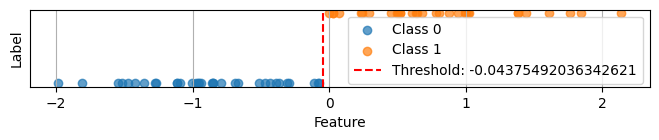

[I:2023-09-01 19:30:48,595][__main__:36] threshold: lower=-0.0763 actual=-0.0438 upper=0.0012
[I:2023-09-01 19:31:01,821][__main__:83] [4999] loss: 0.1469


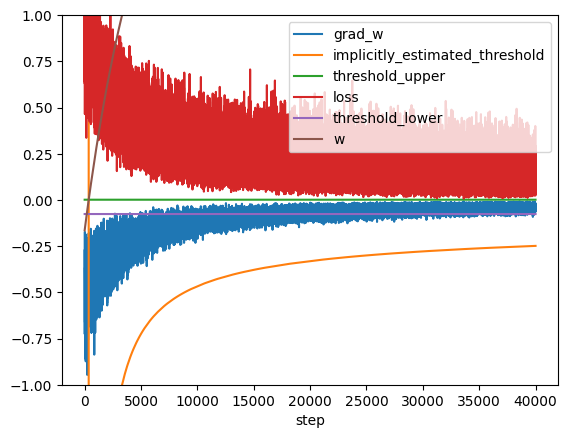

In [23]:
expt = ExperimentFp32OneNeuron(n=64, batch_size=8, lr=1e-3)
expt.threshold = float(0.5 * torch.randn(1).item())
expt.run()

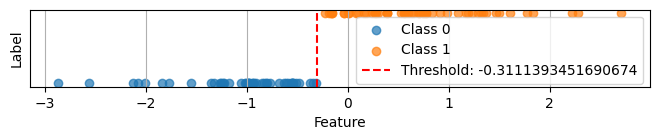

[I:2023-09-01 11:38:45,855][__main__:36] threshold: lower=-0.3184 actual=-0.3111 upper=-0.2292
[I:2023-09-01 11:38:50,013][__main__:83] [4999] loss: 0.0776


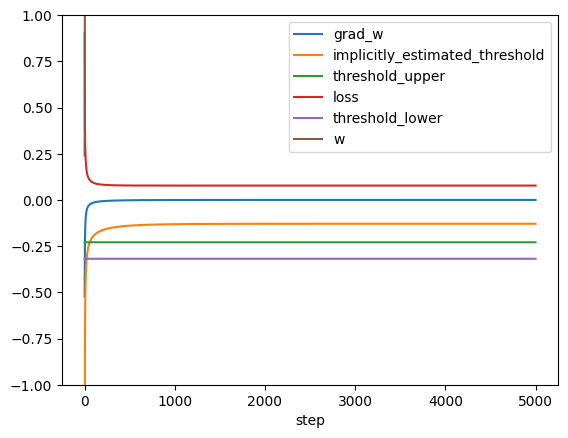

In [16]:
expt = ExperimentFp32OneNeuron(lr=1)
expt.threshold = float(0.25 * torch.randn(1).item())
expt.run()

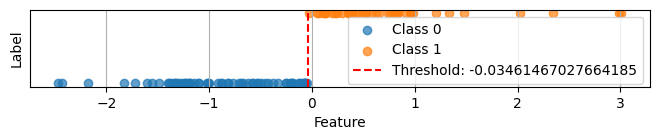

[I:2023-09-01 12:15:03,569][__main__:36] threshold: lower=-0.0513 actual=-0.0346 upper=-0.0260
[I:2023-09-01 12:15:07,632][__main__:83] [4999] loss: 0.0340


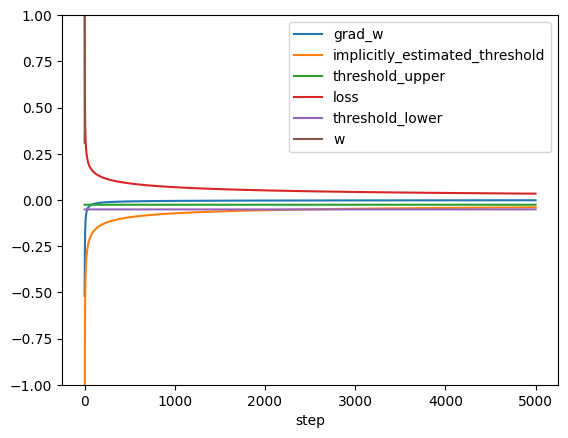

In [17]:
expt = ExperimentFp32OneNeuron(lr=1)
expt.threshold = float(0.05 * torch.randn(1).item())
expt.run()